# Example 4: Setting up and tracking a deformation
Here we will use pyVDERM's tracking functions to deform a non trivial object- a statue of a dragon downloaded from https://www.thingiverse.com/thing:16860

In [ ]:
import pyVDERM as vd
import numpy as np
import matplotlib.pyplot as plt

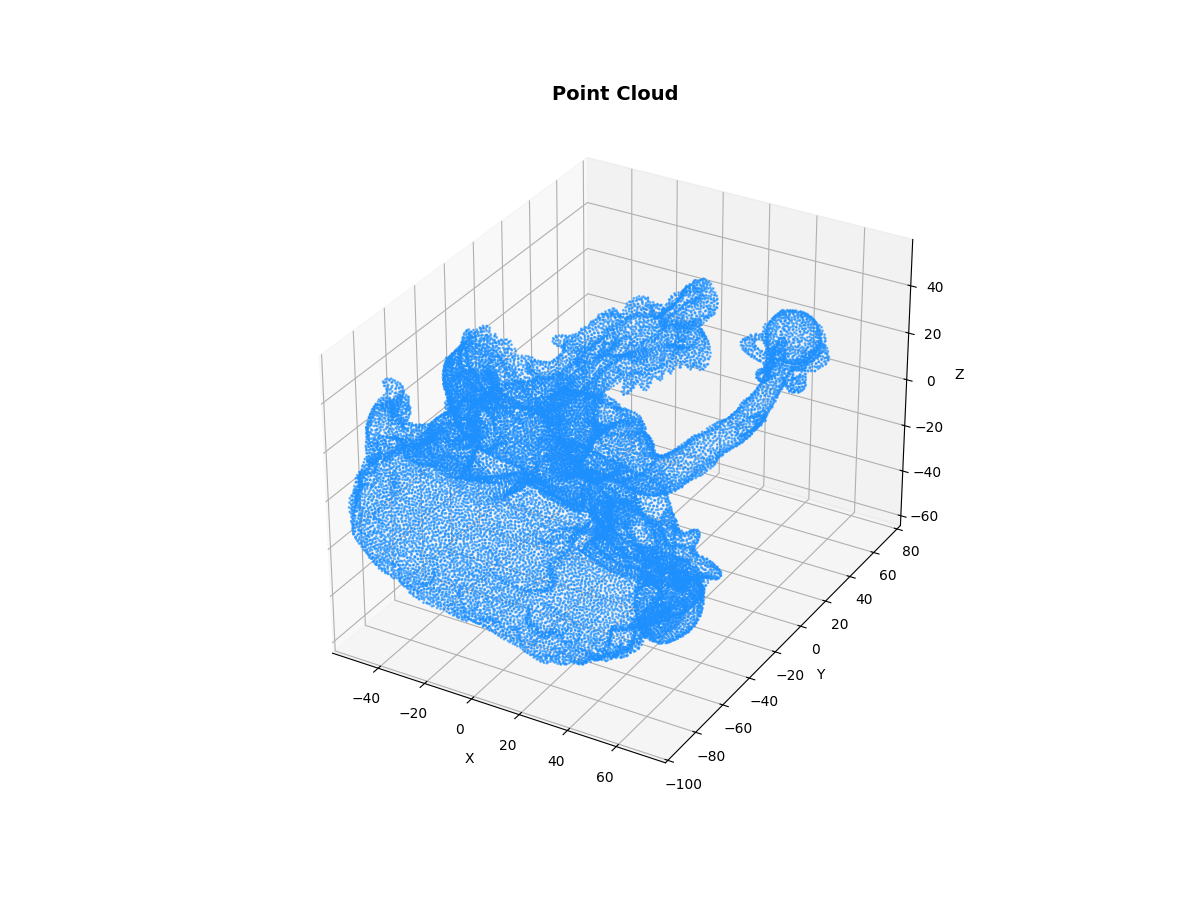

In [2]:
# import the statue and check its positioning and orientation
points, _ = vd.create_pcd('dragon_with_pearl.stl')
fig = vd.plot_pcd(points)

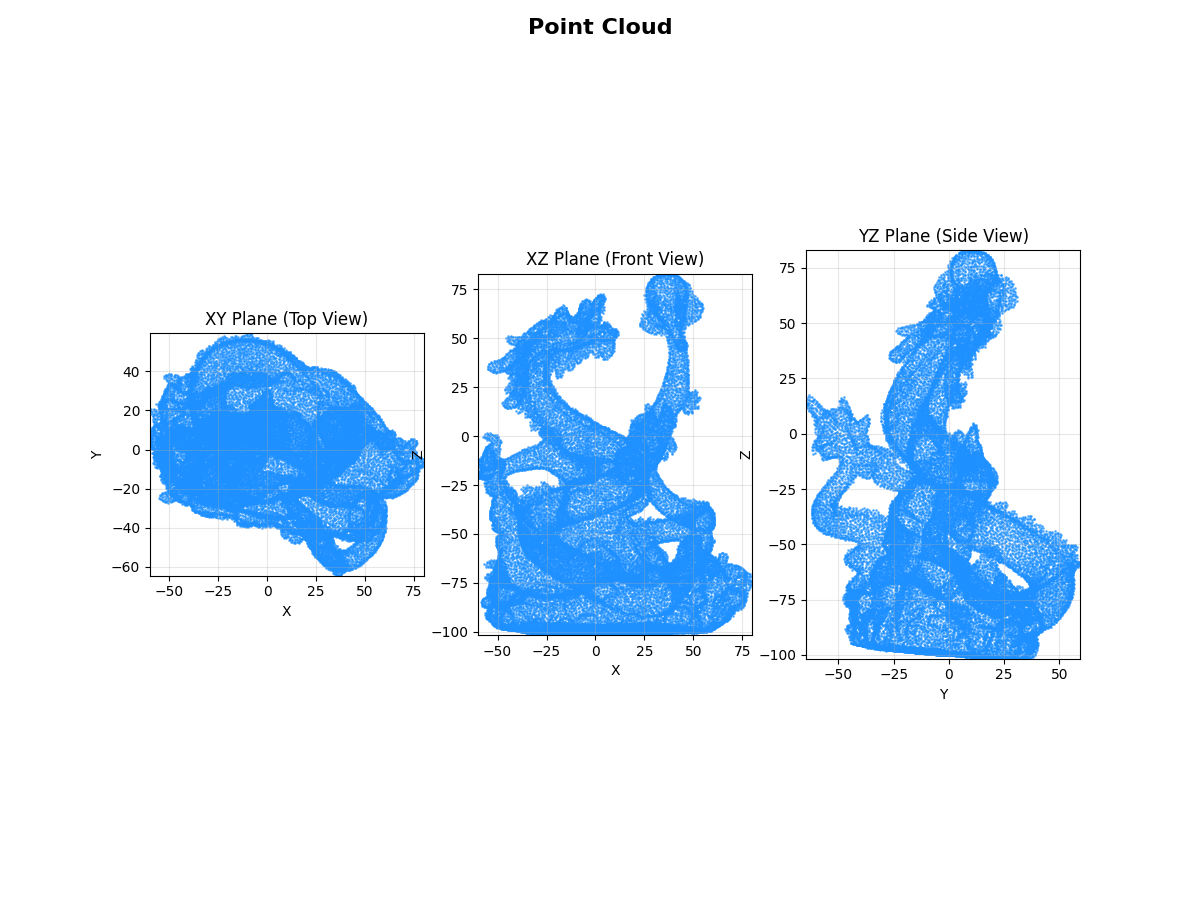

In [3]:
# for convenience, flip the statue up into a more intuitive orientation
for i in range(len(points)):
    points[i] = [points[i][0],points[i][2],points[i][1]]
fig = vd.plot_pcd(points,view='2d')

In [4]:
grid_params = vd.make_initial_grid(points,max_points=60_000,padding=(1.5,1.5,1.5))
vd.print_grid_info(grid_params)

GRID INFORMATION

Grid dimensions: 37 × 33 × 49 = 59,829 points
Grid spacing (h): 5.824403

Grid size:   [209.6785, 186.3809, 279.5714]
Object size: [139.7857, 123.7345, 184.6694]
Ratio:       [1.50x, 1.51x, 1.51x]

Grid bounds:
  x: [-94.8366, 114.8419]
  y: [-95.7402, 90.6407]
  z: [-149.1682, 130.4031]

Object bounds:
  x: [-59.8902, 79.8955]
  y: [-64.4170, 59.3175]
  z: [-101.7173, 82.9522]

Object margins (distance from grid boundary):
  x: min=34.9464, max=34.9464
  y: min=31.3232, max=31.3232
  z: min=47.4510, max=47.4510

Verification for padding ratios:
  x: 1.500x
  y: 1.506x
  z: 1.514x


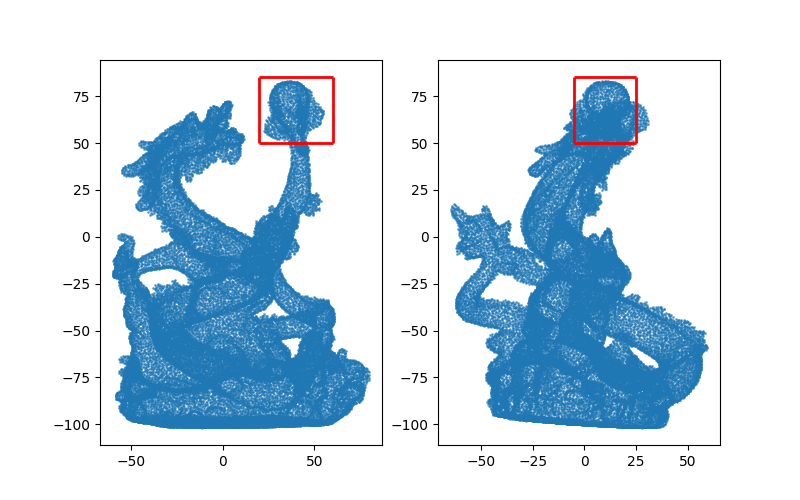

In [6]:
# for this deform, we will simply enlarge the pearl by creating a high density region around it
# first, scatter plot the relevant views
xs = points[:,0]
ys = points[:,1]
zs = points[:,2]
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].scatter(xs,zs,alpha=0.6,s=1)
ax[1].scatter(ys,zs,alpha=0.6,s=1)
# then, draw boxes to define the boundaries of the region
ax[0].hlines(y=[50,85],xmin=[20,20],xmax=[60,60],lw=2,color='r')
ax[1].hlines(y=[50,85],xmin=[-5,-5],xmax=[25,25],lw=2,color='r')

ax[0].vlines(x=[20,60],ymin=[50,50],ymax=[85,85],lw=2,color='r')
ax[1].vlines(x=[-5,25],ymin=[50,50],ymax=[85,85],lw=2,color='r')
# we now know that the x bounds are 20 and 60, the y bounds are -5,25, and the z bounds are 50,85

In [8]:
def pearl_density(x,y,z):
    # apply the boundaries from the previous cell
    if x>20 and x<60 and y>-5 and y<25 and z>50 and z<85:
        return 10
    else:
        return 1
    
vdgrid = vd.VDERMGrid(shape=grid_params['shape'],h=grid_params['h'],min_bounds=grid_params['min_bounds'])
vdgrid.set_density(pearl_density)

## Run VDERM with tracking
Using the run_VDERM_with_tracking function, we can export the grid, the surface, and/or a mesh at frequencies of our choosing. These add computation time and therefore should be exported only as needed. The mesh exports take the longest because it requires a full poisson remesh. The surface exports take less time, but still require interpolation. All exports require density and either velocity or normal vector interpolation. 

In [10]:
final_grid = vd.run_VDERM_with_tracking(
    vdgrid, points, n_max = 5000, max_eps = 0.01,
    export_grid=True, export_grid_frequency=50,
    export_surface=True, export_surface_frequency=100,
    export_mesh=True, export_mesh_frequency=200,
    base_folder='my_deformation'
)

Converged:  58%|█████▊    | 2914/5000 [21:31<15:24,  2.26it/s, ε=9.999e-03, target=1.000e-02]                



Converged at iteration 2915

Exports saved to: my_deformation/
  - Grid states (x y z rho): vderm_grid/
  - Surface point clouds (x y z n_x n_y n_z rho): vderm_surface/
  - Meshes (.stl + .xyz with x y z n_x n_y n_z rho): vderm_mesh/


## Interactive visualization
If ipympl and ipywidgets are installed in the environment, and the matplotlib widget command below is run, point clouds can be viewed interactively in a notebook. This is not the recommended usage, because the replotting is slow, and saving a gif leads to a smoother visualization. For some applications though, being able to easily index back and forth between steps may be desirable

Found 30 files to visualize


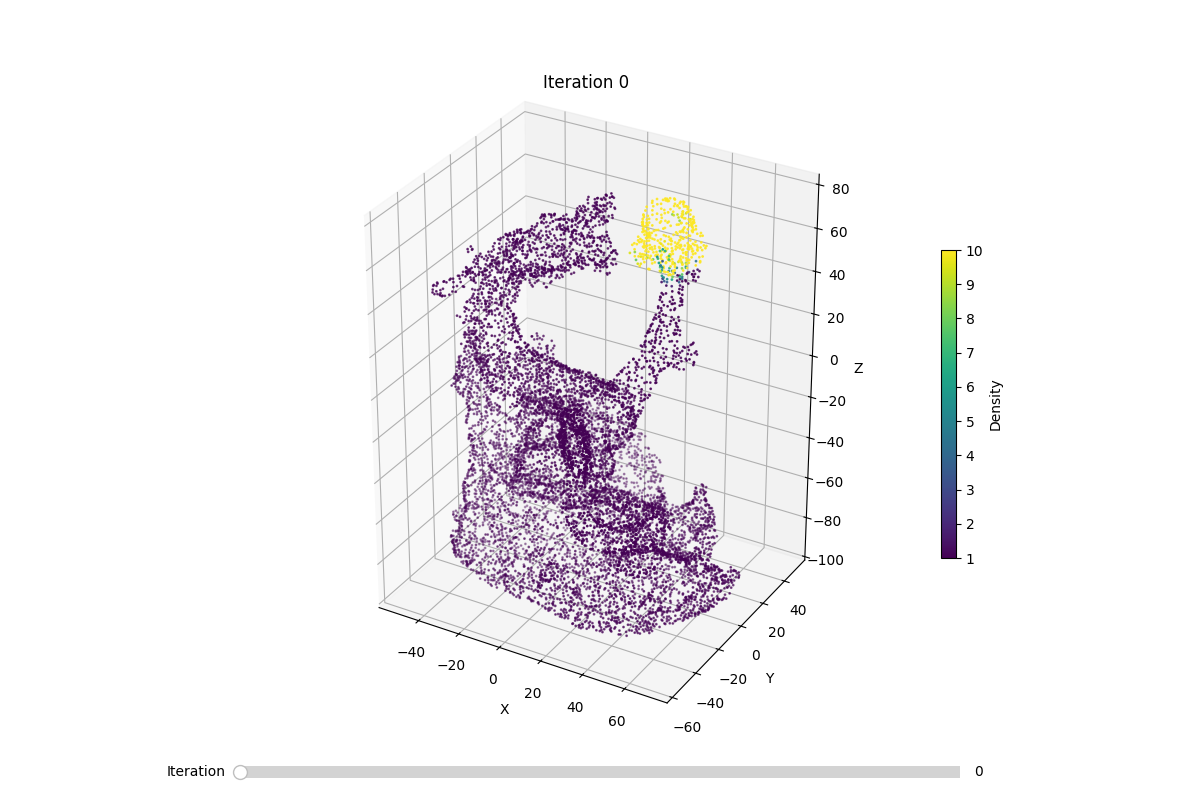

In [11]:
%matplotlib widget
vd.interactive_pcd_plot('./my_deformation/vderm_surface/',pattern='surface_iteration_*.xyz')

## Export plots and gifs
We can now export
1. A gif of the deforming grid
2. A gif of the deforming surface
3. A side by side animation of the grid and the surface
4. A plot of the density equalization over time

In [12]:
vd.animate_grid_deformation('my_deformation', output_file='grid.gif', fps=10,subsample=None,alpha=1)
vd.animate_surface_deformation('my_deformation', output_file='surface.gif', fps=10,subsample=None,alpha=1)
vd.create_side_by_side_animation('my_deformation', output_file='comparison.gif', fps=5,subsample=None,alpha_grid=1,alpha_surface=0.6)
vd.plot_density_evolution('my_deformation', output_file='density_plot.png')

Found 60 frames to animate
Using all 59829 points (no subsampling)


Loading data: 100%|██████████| 60/60 [00:02<00:00, 20.18it/s]


Position range: [-94.837, 114.842] × [-95.740, 90.641] × [-149.168, 130.403]
Density range: [1.000, 10.000]
Creating animation with 10 fps...
Saving to grid.gif...
✓ Animation saved to: grid.gif
Found 31 frames to animate
Using all 34993 points (no subsampling)


Loading data: 100%|██████████| 31/31 [00:00<00:00, 36.21it/s]


Surface bounds: [-59.890, 79.895] × [-64.417, 59.318] × [-101.717, 84.754]
Creating animation with 10 fps...
Saving to surface.gif...
✓ Animation saved to: surface.gif
Creating 30 frame side-by-side animation
Using all 34993 points (no subsampling)
Using all 59829 points (no subsampling)


Loading: 100%|██████████| 30/30 [00:02<00:00, 14.41it/s]


Grid bounds: [-94.837, 114.842] × [-95.740, 90.641] × [-149.168, 130.403]
Surface bounds: [-59.890, 79.895] × [-64.417, 59.318] × [-101.717, 84.746]
Creating animation with 5 fps...
Saving to comparison.gif...
✓ Animation saved to: comparison.gif


Analyzing density: 100%|██████████| 59/59 [00:02<00:00, 22.86it/s]


✓ Density evolution plot saved to: density_plot.png


## Export to paraview (optional)
By converting to vtk files, the animation can be viewed in 3D in paraview.
See function docstrings for more information on opening and viewing the paraview files.

In [15]:
vd.export_all_to_paraview('my_deformation', output_base='./my_deformation/paraview')

# Or export specific types
# vd.export_meshes_to_paraview('my_deformation')  # Just meshes
# vd.export_grid_to_paraview('my_deformation')    # Just grid
# vd.export_surface_to_paraview('my_deformation') # Just surface

# 5. Export for ParaView (professional visualization)
# vd.export_to_paraview('my_deformation')

Converting grid to VTK: 100%|██████████| 60/60 [00:25<00:00,  2.39it/s]


✓ Exported 60 grid files to ./my_deformation/paraview/grid/
  Open ParaView and load the .vtk files to visualize
  Tip: Color by 'density' to see density field evolution
  Tip: Apply 'Glyph' filter with 'velocity' to visualize flow field
       Or use 'Stream Tracer' to show particle trajectories


Converting surface to VTK: 100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


✓ Exported 31 surface files to ./my_deformation/paraview/surface/
  Open ParaView and load the .vtk files to visualize
  Tip: Color by 'density' to see density distribution on surface
  Tip: Apply 'Glyph' filter with 'normals' to visualize normal vectors

NOTE: For ParaView visualization with density vertex attributes,
the recommended approach is to use run_VDERM_with_tracking()
with mesh_format='vtk' instead of converting STL files.

Example:
  run_VDERM_with_tracking(grid, surface_pts, normals,
                          export_mesh=True,
                          mesh_format='vtk')

This function converts existing STL → VTK but cannot include density.



Converting STL to VTK: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


✓ Exported 16 mesh files to ./my_deformation/paraview/meshes/
  Open ParaView and load the .vtk files to visualize
  Tip: In ParaView, use 'Surface With Edges' for best visualization

⚠ These meshes do NOT contain density data.
  To get density coloring in ParaView, use mesh_format='vtk'
  in run_VDERM_with_tracking() instead.


✓ Exported grid, surface, meshes (converted from STL, no density) to ./my_deformation/paraview/

To visualize in ParaView:
  1. Open ParaView
  2. File → Open → Navigate to paraview_exports/
  3. Select all .vtk files in a folder
  4. Click 'Apply' in the Properties panel
  5. Use the time slider to animate through iterations

⚠ Meshes converted from STL do not contain density data.
  For density coloring, re-run with mesh_format='vtk'
